In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
solver_names = {
    "dwave": "DWave",
    "mqlib": "MQLib",
    "gurobi": "Gurobi",
    "pathfinder": "Pathfinder"
}
annotator_names = {
    "mg": "Minigraph",
    "km": "Kmer2node",
    "ga": "GraphAligner"
}

In [3]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [ ]:
data_folder = '/tmp/data'
dtype="cons"

In [ ]:
def get_compare_annotator_data(solvers=["gurobi", "mqlib"]):
    line_labels = []
    spoke_labels = ["%Covered ", "%Used ", "Num. \ncontig ", "Num. break ", "Num. indel ", "Num. \ndiff ", "%Identity "]
    
    data = []
    
    for annotate in ["ga", "km", "mg"]:
        new_data = []
        for solver in solvers:
            
            file = f"{data_folder}/{solver}.{annotate}.{dtype}.avg.parsed.txt"
            with open(file, 'r') as f:
                lines = f.readlines()
            for line in [lines[0], lines[-1]]:
                new_data.append([float(x) for x in line.split(' ')[1:]])
                line_labels.append(f"{solver_names[solver]} {line.split(' ')[0]}")
        
        for solver in ["pathfinder"]:
            file = f"{data_folder}/{solver}.{annotate}.{dtype}.avg.parsed.txt"
            with open(file, 'r') as f:
                lines = f.readlines()
            for line in lines:
                new_data.append([float(x) for x in line.strip().split(' ')])
                line_labels.append(solver_names[solver])
            
        new_data = np.array(new_data)

            
        data.append([annotate, new_data])
    all_data = np.array([d[1] for d in data])
    
    for i in [0, 1, 6]:
        all_data[:, :, i] = all_data[:, :, i] / 100
        spoke_labels[i] = f"{spoke_labels[i]}\n(100)"
        
    for i in [2, 3, 4, 5]:
        min_val = all_data[:, :, i].min()
        max_val = all_data[:, :, i].max()
        all_data[:, :, i] = 1 - all_data[:, :, i] / max_val + min_val/max_val
        spoke_labels[i] = f"{spoke_labels[i]}\n({np.round(min_val,1)})"
        
    for i in range(len(data)):
        data[i][1] = all_data[i, :, :]
    return data, spoke_labels, line_labels

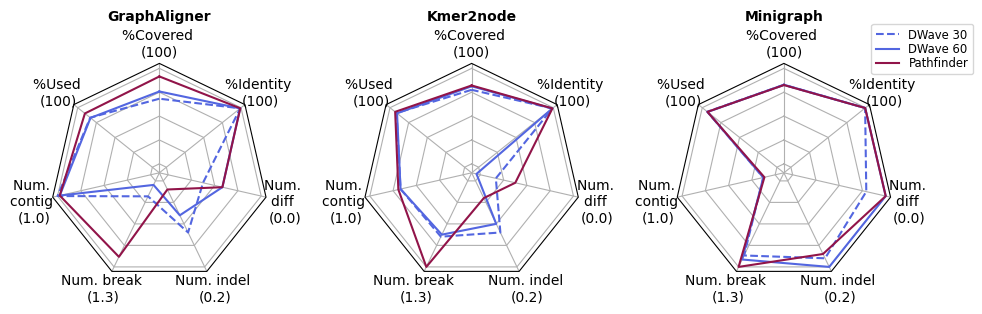

In [ ]:
solvers = ["dwave"]
# solvers = ["gurobi", "mqlib"]
data, spoke_labels, labels = get_compare_annotator_data(solvers)

N = data[0][1].shape[1]
num_time_limits = int((data[0][1].shape[0] - 1)/len(solvers))

theta = radar_factory(N, frame='polygon')

fig, axs = plt.subplots(figsize=(10,5), nrows=1, ncols=3,
                        subplot_kw=dict(projection='radar'),sharey=True)
fig.subplots_adjust(wspace=1, hspace=1, top=0.85, bottom=0.05)


colors = ['#5366E0', '#13553A', '#911449']
styles = [':', '-.', '--', '-']

colors_for_lines = list(
    np.array(
        [[colors[i]] * num_time_limits for i in range(len(solvers))]
    ).reshape((num_time_limits * len(solvers),))
) + [colors[-1]]
styles_for_lines = styles[-num_time_limits:] * len(solvers) + [styles[-1]]

for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8,1])
    ax.set_title(annotator_names[title], weight='bold', size='medium', position=(0.5, 1.5),
                    horizontalalignment='center')
    for i in range(case_data.shape[0]):
        ax.plot(theta, case_data[i,:], color=colors_for_lines[i], linestyle=styles_for_lines[i])  
    ax.set_varlabels(spoke_labels)
    ax.set_yticklabels([])

legend = axs[2].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')



fig.tight_layout()
plt.show()

In [ ]:
def get_compare_solver_data(solvers=["gurobi", "mqlib", "pathfinder"]):
    line_labels = []
    spoke_labels = ["%Covered ", "%Used ", "Num. \ncontig ", "Num. break ", "Num. indel ", "Num. \ndiff ", "%Identity "]
    
    data = []
    
    for solver in solvers:
        new_data = []
        for annotate in ["ga", "km", "mg"]:
            
            file = f"{data_folder}/{solver}.{annotate}.{dtype}.avg.parsed.txt"
            with open(file, 'r') as f:
                lines = f.readlines()
                        
            new_data.append([float(x) for x in lines[-1].split(' ')[1:]])
            line_labels.append(f"{annotator_names[annotate]}")
                    
        new_data = np.array(new_data)    
        data.append([solver_names[solver], new_data])
        
    all_data = np.array([d[1] for d in data])
    
    for i in [0, 1, 6]:
        all_data[:, :, i] = all_data[:, :, i] / 100
        spoke_labels[i] = f"{spoke_labels[i]}\n(100)"
            
    for i in [2, 3, 4, 5]:
        min_val = all_data[:, :, i].min()
        max_val =  all_data[:, :, i].max()
        all_data[:, :, i] = 1 - all_data[:, :, i] / max_val + min_val/max_val
        spoke_labels[i] = f"{spoke_labels[i]}\n({np.round(min_val,1)})"
    for i in range(len(data)):
        data[i][1] = all_data[i, :, :]
        
    return data, spoke_labels, line_labels

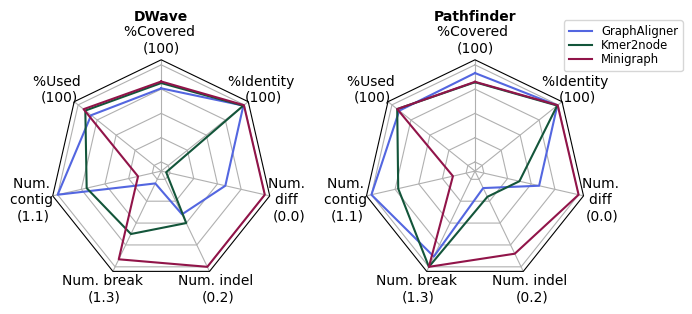

In [ ]:
solvers = ["dwave", "pathfinder"]
# solvers = ["gurobi", "mqlib", "pathfinder"]
data, spoke_labels, labels = get_compare_solver_data(solvers)

N = data[0][1].shape[1]
theta = radar_factory(N, frame='polygon')

width = 7 if len(solvers) == 2 else 10
fig, axs = plt.subplots(figsize=(width,5), nrows=1, ncols=len(solvers),
                        subplot_kw=dict(projection='radar'),sharey=True)

colors = ['#5366E0', '#13553A', '#911449']
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8,1])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for i in range(len(case_data)):
        ax.plot(theta, case_data[i], color=colors[i]) # 
    ax.set_varlabels(spoke_labels)
    ax.set_yticklabels([])
    

legend = axs[-1].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')


fig.tight_layout()
plt.show()

In [ ]:
def get_violin_plot_data(solvers: list[str]=["gurobi", "mqlib", "pathfinder"]):
    line_labels = []
    new_data = []
    for solver in solvers:
        for annotate in ["ga", "km", "mg"]:
            
            file = f"{data_folder}/{solver}.{annotate}.{dtype}.violin.txt"
            with open(file, 'r') as f:
                lines = f.readlines()

            in_data = False
            data = []        
            for line in lines:
                if not in_data:
                    # time_limit = int(line)
                    in_data = True
                elif line[0] == '-':
                    in_data = False
                    new_data.append(data)
                    data = []
                    line_labels.append(annotator_names[annotate])
                else:
                    data.append(float(line))
            
                    
    return new_data, line_labels
            
        

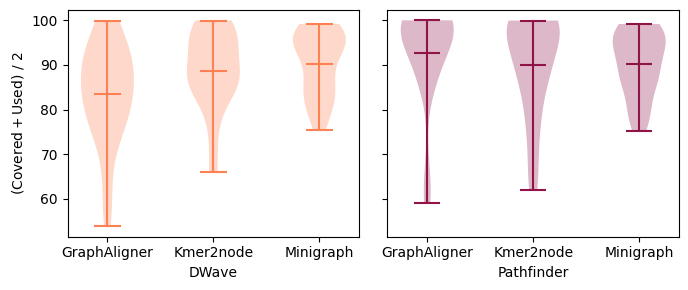

In [ ]:
solvers = ["dwave", "pathfinder"]
# solvers = ["gurobi", "mqlib", "pathfinder"]
data, line_labels = get_violin_plot_data(solvers)

width = 10 if len(solvers) == 3 else 7

fig, axs = plt.subplots(1,len(solvers), figsize=(width, 3), sharey=True)

num_time_limits = 2


parts = axs[0].violinplot(data[num_time_limits-1:4*num_time_limits-1:num_time_limits], showmeans=True)
col = '#FD8153'
for pc in parts['bodies']:
    pc.set_facecolor(col)
parts['cmeans'].set_color(col)
parts['cbars'].set_color(col)
parts['cmins'].set_color(col)
parts['cmaxes'].set_color(col)


if len(solvers) == 3:
    col = '#13553A'
    parts = axs[1].violinplot(data[4*num_time_limits-1:7*num_time_limits-1:num_time_limits], showmeans=True)
    for pc in parts['bodies']:
        pc.set_facecolor(col)
    parts['cmeans'].set_color(col)
    parts['cbars'].set_color(col)
    parts['cmins'].set_color(col)
    parts['cmaxes'].set_color(col)

col = '#911449'
parts = axs[-1].violinplot(data[3*(len(solvers)-1)*num_time_limits:], showmeans=True)
for pc in parts['bodies']:
    pc.set_facecolor(col)
parts['cmeans'].set_color(col)
parts['cbars'].set_color(col)
parts['cmins'].set_color(col)
parts['cmaxes'].set_color(col)

axs[0].set_xticks(np.arange(1, len(line_labels[num_time_limits-1:4*num_time_limits-1:num_time_limits]) + 1), labels=line_labels[num_time_limits-1:4*num_time_limits-1:num_time_limits])
axs[0].set_xlabel(solver_names[solvers[0]])

axs[1].set_xticks(np.arange(1, len(line_labels[4*num_time_limits-1:7*num_time_limits-1:num_time_limits]) + 1), labels=line_labels[4*num_time_limits-1:7*num_time_limits-1:num_time_limits])
axs[1].set_xlabel(solver_names[solvers[1]])

axs[-1].set_xticks(np.arange(1, len(line_labels[3*(len(solvers)-1)*num_time_limits:]) + 1), labels=line_labels[3*(len(solvers)-1)*num_time_limits:])
axs[-1].set_xlabel(solver_names[solvers[-1]])


axs[0].set_ylabel(r'$(\text{Covered} + \text{Used})\ / \ 2$')


fig.tight_layout()

plt.show()